# DMD: Distribution Matching Distillation

One-step Diffusion with Distribution Matching Distillation, Yin et al., 2023. [[arXiv:2311.18828](https://arxiv.org/abs/2311.18828)]

## 1. Prepare Dataset

Define the gaussian mixture distribution as the target distribution.

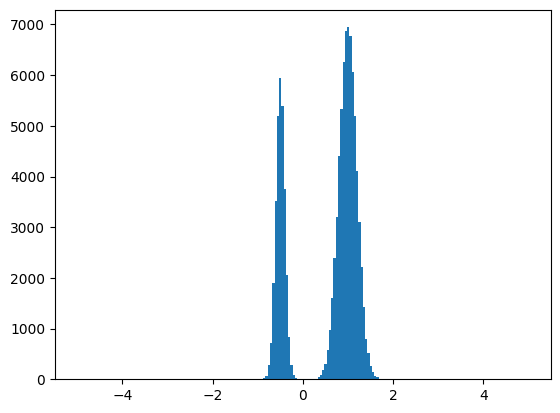

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributions as D

mixture = D.MixtureSameFamily(
    D.Categorical(torch.tensor([0.3, 0.7])),
    D.Normal(torch.tensor([-0.5, 1.0]), torch.tensor([0.1, 0.2])),
)
# target distribution
X = mixture.sample((100000, 1))

_ = plt.hist(X, bins=np.linspace(-5, 5, 200), label="data")

## 2. Define Score Model

Define MLP backbone and score model first.

In [2]:
import torch
import torch.nn as nn

from flowmodels import VESDE, VESDEScheduler


class Backbone(nn.Module):
    def __init__(self, dim: int = 1, layers: int = 3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, 64),
            *[
                submodule
                for _ in range(layers)
                for submodule in (nn.ReLU(), nn.Linear(64, 64))
            ],
            nn.ReLU(),
            nn.Linear(64, dim),
        )

    def forward(self, x_t: torch.Tensor, t: torch.Tensor | None = None) -> torch.Tensor:
        if t is None:
            bsize, *_ = x_t.shape
            t = x_t.new_ones(bsize)
        return self.net.forward(torch.cat([x_t, t[:, None].to(x_t)], dim=-1))


model = VESDE(Backbone(), VESDEScheduler())
model

VESDE(
  (score_estim): Backbone(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): ReLU()
      (8): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

## 3. Train Score Model

Train the score model with the prepared dataset.

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

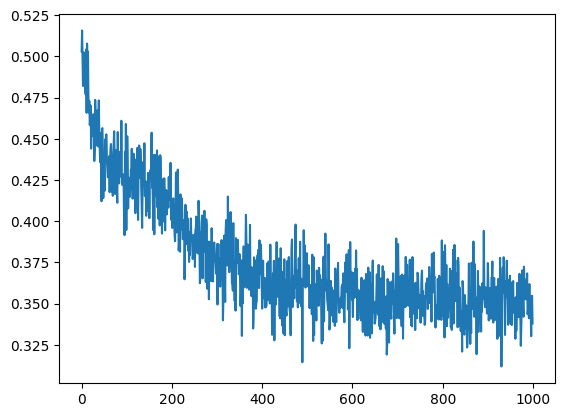

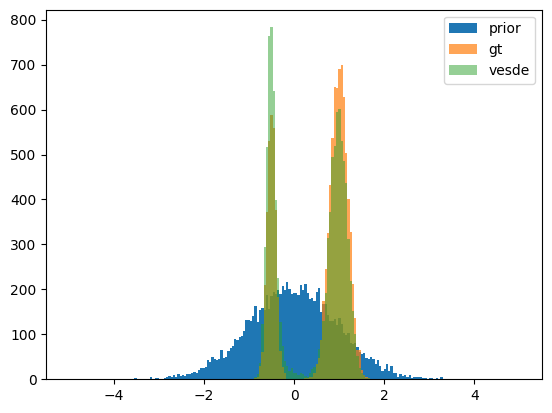

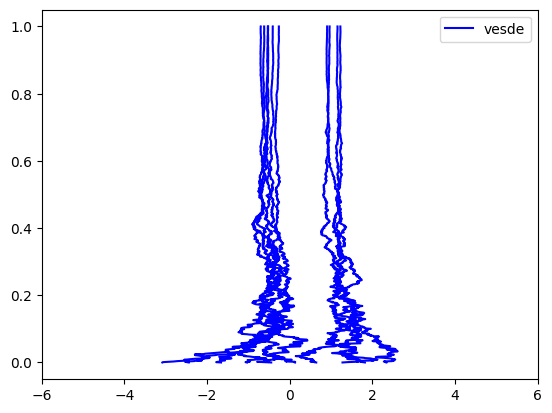

In [3]:
import torch
from tqdm.auto import tqdm

# training configurations
LR = 0.001
TRAIN_STEPS = 1000
BATCH_SIZE = 2048

# train
model.train()
optim = torch.optim.Adam(model.parameters(), LR)

losses = []
with tqdm(range(TRAIN_STEPS)) as pbar:
    for i in pbar:
        loss = model.loss(sample=X[torch.randint(0, len(X), (BATCH_SIZE,))])
        # update
        optim.zero_grad()
        loss.backward()
        optim.step()

        # log
        loss = loss.detach().item()
        losses.append(loss)
        pbar.set_postfix_str(f"loss: {loss:.2f}")

plt.plot(losses)

# plot histogram
n = 10000
sample = torch.randn(n, X.shape[-1])
x_t, _ = model.sample(sample, verbose=lambda x: tqdm(x, leave=False))

plt.figure()
plt.hist(sample, bins=np.linspace(-5, 5, 200), label="prior")
plt.hist(X[:n], bins=np.linspace(-5, 5, 200), label="gt", alpha=0.7)
plt.hist(x_t.view(-1), bins=np.linspace(-5, 5, 200), label="vesde", alpha=0.5)
plt.legend()
_xticks, _ = plt.xticks()

# plot trajectory
n = 200
x_t, x_ts = model.sample(torch.linspace(-3, 3, n)[:, None])

plt.figure()
for i in range(10):
    plt.plot(
        torch.tensor([_x_t[i * 20].item() for _x_t in x_ts]),
        np.linspace(0, 1, len(x_ts)),
        "b",
        **({} if i > 0 else {"label": "vesde"}),  # labeling on first plot only
    )
    plt.xticks(_xticks)
plt.legend()

## 4. Distribution Matching Distillation

Distill the knowledge of the pretrained score model to one-step generator

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

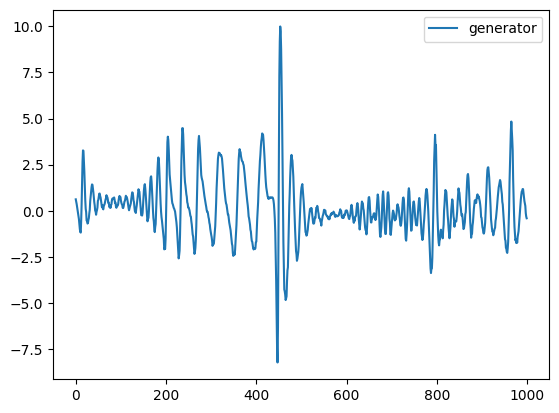

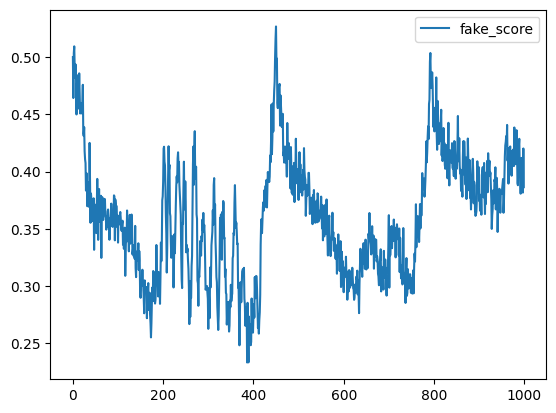

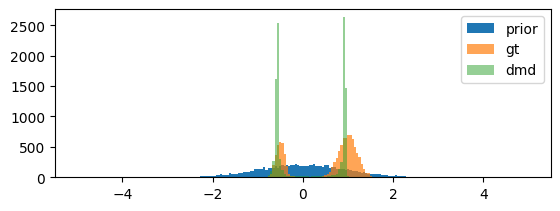

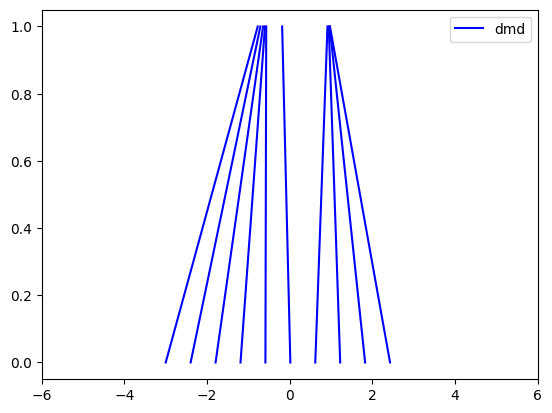

In [4]:
from flowmodels import DistributionMatchingDistillation

onestep = DistributionMatchingDistillation(
    Backbone(X.shape[-1]),
    VESDE(Backbone(X.shape[-1]), VESDEScheduler()),
)

# distillation
LR = 0.001
SAMPLE_STEPS = 100
TRAIN_STEPS = 1000
BATCH_SIZE = 2048

n = 10000
prior = torch.randn(n, X.shape[-1])
optim_g = torch.optim.Adam(onestep.generator.parameters(), LR)
optim_s = torch.optim.Adam(onestep.fake_score.parameters(), LR)
g_losses, s_losses = onestep.dmd(
    model,
    optim_g,
    optim_s,
    TRAIN_STEPS,
    BATCH_SIZE,
    prior,
    verbose=lambda r: tqdm(r, leave=False),
    _lambda=1.,
)
plt.figure()
plt.plot(g_losses, label="generator")
plt.legend()

plt.figure()
plt.plot(s_losses, label="fake_score")
plt.legend()

# plot histogram
with torch.inference_mode():
    x_t, x_ts = onestep.sample(prior)
plt.figure()
plt.subplot(2, 1, 1)
plt.hist(sample, bins=np.linspace(-5, 5, 200), label="prior")
plt.hist(X[:n], bins=np.linspace(-5, 5, 200), label="gt", alpha=0.7)
plt.hist(x_t.view(-1), bins=np.linspace(-5, 5, 200), label="dmd", alpha=0.5)

plt.legend()
xticks, _ = plt.xticks()

# plot trajectory
_space = torch.linspace(-3, 3, 200)
with torch.inference_mode():
    x_t, x_ts = onestep.sample(_space[:, None])
plt.figure()
for i in range(10):
    plt.plot(
        torch.tensor([_space[i * 20].item()] + [_x_t[i * 20].item() for _x_t in x_ts]),
        np.linspace(0, 1, len(x_ts) + 1),
        "b",
        **({} if i > 0 else {"label": "dmd"}),
    )
    plt.xticks(xticks)
plt.legend()